Semblance, Coherence, and other Discontinuity Attributes
==============================

Introduction
------------

Discontinuity attributes are a variety of post-stack calculations that measure
the degree of local similarity or dis-similarity between seismic traces.
Discontinuities in a seismic volume, such as faults or mass transport deposits,
are apparent as regions of low similarity.  Therefore, discontinuity
attributes are most often applied to highlight faults in a seismic volume,
but are also useful to detect subtle stratigraphic features in map view.
Discontinuity attributes such as semblance-based coherence (Marfurt, et al, 1998),
eigenstructure-based coherence (Gersztenkorn and Marfurt, 1999), and many other
similar algorithms are among the most widely applied seismic attributes today.

However, the terminology used for discontinuity attributes in practice can be
very confusing.  Terms such as "coherence", "semblance", "similarity",
"discontinuity" and many others are used to refer to both the general class
of attribute and to specific algorithms.  Different software vendors market
their discontinuity algorithms under a variety of names, which can add to the
confusion over terminology. In the literature, "coherence" is most often used
to refer to the general class of attributes that measure similarity between
adjacent post-stack traces. The terms "coherence" and "semblance" come from conceptually
similar pre-stack methods, which can lead to confusion between the post-stack
attributes discussed here and the stacking velocity estimation method (Taner & Koehler 1969).  To
further complicate matters, "coherence" is sometimes used informally to
distinguish semblance-based coherence attributes (e.g. Marfurt, et al, 1998)
from eigenstructure-based coherence (Gersztenkorn and Marfurt, 1999). For these
reasons, in this tutorial we'll use the term "discontinuity" to refer to the
general class of attribute. Specific algorithms will always include a reference
in addition to the name the original author used to avoid confusion.

In practice, most discontinuity attributes are calculated and applied in
proprietary seismic interpretation packages.  The exact algorithm used by a
particular package is sometimes a considered a trade secret or may be
undocumented.  This can make it difficult to fully understand the trade-offs
between different algorithms in different software packages.  For that
reason, we won't directly refer to or compare commercially available
implementations in this tutorial. However, most proprietary discontinuity
attributes are similar to (or based on) published algorithms.  Therefore,
understanding widely cited published algorithms for discontinuity is a good
first step to understanding the trade-offs between different commercial
implementations.

We'll focus on demonstrating a few of the most cited published discontinuity
algorithms with short Python code snippets using the numpy, scipy, and matplotlib Python libraries.  The data we'll be working with is a small subset of the
Penobscot 3D seismic dataset from offshore Nova Scotia, owned by the Nova
Scotia Department of Energy and distributed by dGB Earth Sciences under an
CC-BY-SA license (https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND). These examples eschew practical considerations
(e.g. memory usage and speed) and focus on demonstrating the algorithm using
high-level concepts.  


Setup
-------

First off, the code in this tutorial depends on Python (2.7 or 3.x) and recent-ish versions of numpy, scipy, and matplotlib.  For 3D visualization, there's an optional dependence on mayavi.



In [1]:
# We'll use non-interactive matplotlib figures embedded in the notebook, for the moment
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal

# Local files included with the notebook
# Note that the "data" folder also has an __init__.py file:
import data

Let's define a simple plotting fuction to view a crossline and time slice through a 3D numpy array (we'll use this extensively later):

In [2]:
def plot(data, title=''):
    j0 = data.shape[1] // 2
    k0 = data.shape[2] // 2
    
    # Our data has a fairly narrow time range, so we'll make a cross section that's
    # 1/3 the height of the time slice
    gs = plt.GridSpec(4, 1)
    fig = plt.figure(figsize=plt.figaspect(1.1))
    ax1 = fig.add_subplot(gs[:-1], anchor='S')
    ax2 = fig.add_subplot(gs[-1], anchor='N')
    
    ax1.imshow(data[:,:,k0].T, cmap='gray')
    ax2.imshow(data[:,j0,:].T, cmap='gray')
    
    # Mark the cross section locations...
    for ax, loc in zip([ax1, ax2], [j0, k0]):
        ax.axhline(loc, color='red')
        ax.set(xticks=[], yticks=[])
    
    ax1.set(title=title)
    plt.show()

Our Dataset
-------------

Now let's take a look at our input dataset. The data we'll be working with is a small subset of the Penobscot 3D seismic dataset from offshore Nova Scotia, owned by the Nova
Scotia Department of Energy and distributed by dGB Earth Sciences under an
CC-BY-SA license.

Note: If you'd like these figures to be interactive matplotlib plots, remove or comment out the ``%matplotlib inline`` command, restart the IPython kernel, and re-run.

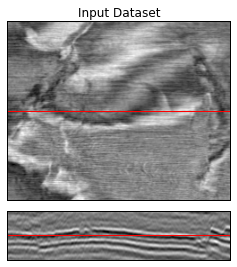

In [3]:
seismic = data.load_seismic()
plot(seismic, 'Input Dataset')

On the right side of the figure, there's a normal fault that tips out towards the top of the time slice.  There are additional features visible in both the time slice and cross section, however, they're difficult to interpret without more detailed investigation.

Speaking of more detailed investigation, you can also explore this dataset in a 3D viewer if you have Mayavi installed. (Click and drag on the secions to move them through the volume.)

In [4]:
from mayavi import mlab

def explore3d(data_cube):
    source = mlab.pipeline.scalar_field(data_cube)
    source.spacing = [1, 1, -1]

    nx, ny, nz = data_cube.shape
    mlab.pipeline.image_plane_widget(source, plane_orientation='x_axes', 
                                     slice_index=nx//2, colormap='gray')
    mlab.pipeline.image_plane_widget(source, plane_orientation='y_axes', 
                                     slice_index=ny//2, colormap='gray')
    mlab.pipeline.image_plane_widget(source, plane_orientation='z_axes', 
                                     slice_index=nz//2, colormap='gray')
    mlab.show()

explore3d(seismic)

Now we're ready to explore some various discontinuity attributes.  We'll review things in roughly historical order, starting with the earliest approach: Bahorich and Farmer (1995).

Early Algorithms - Cross-correlation
----------------

The earliest discontinuity algorithm was developed by Bahorich and Farmer
(1995) and used the maximum cross correlation value of three traces.  Bahorich
and Farmer coined the term "coherence" for the attribute, based on its
conceptual similarity to pre-stack methods for estimating stacking velocities.
While this exact approach is computationally expensive and not widely used
today, it provides a good starting point to understand later algorithms.

In Bahorich and Farmer's (1995) method, each trace is correlated with a
"moving-window" subset of two neighboring traces. We can demonstrate this with
the python function shown below:

In [5]:
def bahorich_coherence(data, zwin):
    ni, nj, nk = data.shape
    out = np.zeros_like(data)
    padded = np.pad(data, ((0, 0), (0, 0), (zwin//2, zwin//2)), mode='reflect')

    for i, j, k in np.ndindex(ni - 1, nj - 1, nk - 1):
        center_trace = data[i,j,:]
        center_std = center_trace.std()
        x_trace = padded[i+1, j, k:k+zwin]
        y_trace = padded[i, j+1, k:k+zwin]

        xcor = np.correlate(center_trace, x_trace)
        ycor = np.correlate(center_trace, y_trace)

        px = xcor.max() / (xcor.size * center_std * x_trace.std())
        py = ycor.max() / (ycor.size * center_std * y_trace.std())
        out[i,j,k] = np.sqrt(px * py)

    return out

Now, let's apply this to our test dataset.  Note that we'll need to use a relatively long ``zwin`` window, and that this will take quite some time (5-15 minutes) to compute:

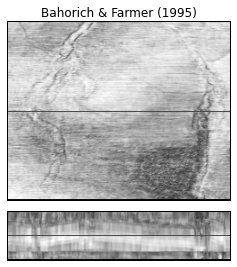

In [6]:
bahorich = bahorich_coherence(seismic, 21)
plot(bahorich, 'Bahorich & Farmer (1995)')

Compared to the "raw" seismic data, this time slice is much easier to interpret. Notice the sinuous features on the left.  While there is likely some minor faulting, these are easily interpretable as channels in this view, while they were unclear in the timeslice of the "raw" data.

Similar to before, we can view it in 3D if Mayavi is available:

In [7]:
explore3d(bahorich)

If you have time, try varying the ``zwin`` value from 21 to something shorter and longer.  Note that with short windows, the result quickly becomes unclear.  This is because the cross-correlation implictly centers the portion of the trace we're using on its mean, instead of the "true" zero.  For longer traces, the mean is usually zero, but short regions of a trace often hae a non-zero mean.  Due to this, Bahorich and Farmer's algorithm requires large windows and is expensive to compute. 

Generalization to an Arbitrary Number of Traces
-----------------------------------------------
Bahorich and Farmer's (1995) approach was very successful, but it is
sensitive to noise because only three traces are used. Marfurt, et al (1998)
generalized Bahorich and Farmer's cross-correlation approach to an arbitrary
number of input traces, referred to by the authors as "semblance-based
coherence". Marfurt et al's approach also exploits our knowledge that the data
is zero-centered, and avoids centering on the mean of the trace, rather than
the "true" mean of 0. As an example (Note: we'll reuse the ``moving_window``
function in future examples):

In [8]:
def moving_window(data, window, func):
    wrapped = lambda region: func(region.reshape(window))
    return scipy.ndimage.generic_filter(data, wrapped, window)

def marfurt_semblance(region):
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    square_of_sums = np.sum(region, axis=0)**2
    sum_of_squares = np.sum(region**2, axis=0)
    return square_of_sums.sum() / sum_of_squares.sum() / ntraces

Now we can apply this to our data (note that it will take a minute or two to compute):

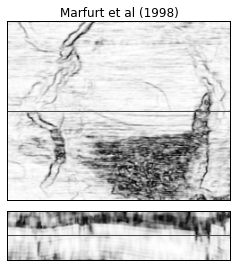

In [9]:
marfurt = moving_window(seismic, (3, 3, 9), marfurt_semblance)
plot(marfurt, 'Marfurt et al (1998)')

Note that both the channels on the left and the fault on the right have become much more clear.  Also, we can now see a discontinuous region (a mass transport complex) in the lower right portion of the timeslice.  We're even starting to get hints of other channels near the upper-left portion of the figure.

Once again, we can visualize this in 3D, if desired:

In [10]:
explore3d(marfurt)

From an algorithmic perspective, this is somewhat similar to Bahorich and Farmer's (1995) approach if the
cross-correlation is only measured at a lag of zero, instead of the maximum
cross correlation. However, Marfurt et al's (1998) method does require a long
vertical window to produce clear results, leading to faster computational times
and better resolution in the time-direction.  Furthermore, because more
adjacent traces are used, this method is less sensitive to noise, resulting in
a more interpretable result .

Conceptually, Marfurt, et al's (1998) algorithm treats each seismic trace
within the moving window as a separate dimension and measures how close the
resulting point cloud is to a hyper-plane with a slope of 1 in all directions
and intercept of 0.  It's easiest to visualize for the case of two traces, as
shown in below.  In that case, the x-axis is one trace's amplitude, the
y-axis is another, and each sample forms a point.  Semblance-based coherence
computes how close the points fall to a line with a slope of 1 and intercept of
0.

<img src="images/marfurt_semblance_traces.png" width="40%">

It is also possible to express this algorithm in terms of a covariance matrix,
where each trace is treated as a separate dimension.  This is mathematically
identical to the example given above, but as we'll see shortly, computing the
covariance matrix allows for other approaches:

In [11]:
def marfurt_semblance2(region):
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    cov = region.dot(region.T)
    return cov.sum() / cov.diagonal().sum() / ntraces

This yields a completely identical result as the implementation shown before. 

Removing Amplitude Sensitivity
------------------------------

One caveat to both Marfurt, et al's (1998) and Bahorich and Farmer's (1995)
method is that they're sensitive to lateral differences in amplitude as well as
differences in phase.  While this is desirable for detecting stratigraphic
features, differences due to lateral changes in amplitude can obscure subtle
structural features.  Gersztenkorn and Marfurt (1999) proposed an
implementation that is sensitive only to lateral changes in phase of the input
waveforms, and not to changes in amplitude: "eigenstructure-based coherence".

Eigenstructure-based coherence (Gersztenkorn and Marfurt, 1999) computes the
covariance matrix of the input region, similar to the previous example.
However, it uses the ratio of the largest eigenvalue of the covariance matrix
to the sum of the eigenvalues:

In [12]:
def gersztenkorn_eigenstructure(region):
    region = region.reshape(-1, region.shape[-1])

    cov = region.dot(region.T)
    vals = np.linalg.eigvalsh(cov)
    return vals.max() / vals.sum()

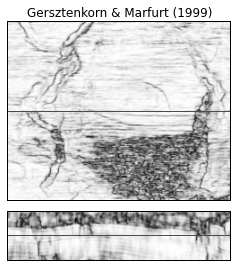

In [13]:
gersztenkorn = moving_window(seismic, (3, 3, 9), gersztenkorn_eigenstructure)
plot(gersztenkorn, 'Gersztenkorn & Marfurt (1999)')

Conceptually, this is similar to treating each seismic trace within the moving
window as a separate dimension and calculating how well the resulting point
cloud is fit by a plane.  To contrast with Marfurt, et al's (1998)
method, for the case of two traces, this measures the scatter about the
best-fit line instead of a line with a slope of 1, as shown below:

<img src="images/sembl_eigenstructure_comparison.png" width="70%">

Let's look at this side-by-side with Marfurt, et al's (1998) algorithm:

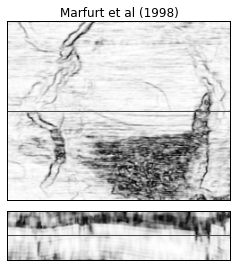

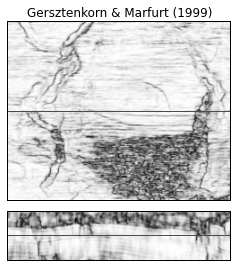

In [14]:
plot(marfurt, 'Marfurt et al (1998)')
plot(gersztenkorn, 'Gersztenkorn & Marfurt (1999)')

Note that Marfurt et al's (1998) method shows more "bold" edges of the channels on the left side of the timeslice.  Because these channels are partly defined by amplitude changes, Gersztenkorn & Marfurt's (1999) approach actually dims the channel edges slightly.  However, it sharpens and more clearly shows fault locations and the internal structure of the mass transport complex at the bottom of the timeslice. This is a good example of the subtle trade-offs between different discontinuity algorithms.

Dip-correction
----------------

A drawback to Marfurt, et al's (1998) and Gersztenkorn and Marfurt's (1999)
approaches is that dipping reflectors will have a uniformly higher
discontinuity (lower coherence/similarity) than non-dipping reflectors. In
other words, these attributes don't distinguish between regional structural dip and
localized discontinuities due to faulting, etc. Therefore, Marfurt
(2006) proposed calculating and correcting for structural dip when performing
discontinuity calculations.   This correction can be applied to any of the
different algorithms discussed so far.  While there are a number of different
methods that can be used to both calculate and correct for structural dip (see
Ch. 2 of Chopra and Marfurt (2007) for a review), dip calculations are beyond
the scope of this tutorial.  Therefore, we'll approximate a dip correction by
flattening on a pre-picked horizon in the interval of interest before applying
a discontinuity calculation (Fig REF).  

In [15]:
def flatten(data, surface, window):
    surface = scipy.ndimage.gaussian_filter(surface.astype(float), 3)

    ni, nj, nk = data.shape
    ik = np.arange(nk)
    out_ik = np.arange(window) - window // 2

    out = np.zeros((ni, nj, window))
    for i, j in np.ndindex(ni, nj):
        trace = data[i,j,:]
        k = surface[i, j]
        shifted = np.interp(out_ik + k, ik, trace)

        out[i,j,:] = shifted

    return out

def unflatten(data, surface, orig_shape):
    out = np.zeros(orig_shape)
    surface = np.clip(surface, 0, orig_shape[-1] - 1)

    win = data.shape[-1] // 2
    for i, j in np.ndindex(orig_shape[0], orig_shape[1]):
        k = surface[i,j]

        outmin, outmax = max(0, k - win), min(orig_shape[-1], k + win + 1)
        inmin, inmax = outmin - (k - win), k + win + 1 - outmax
        inmax = data.shape[-1] - abs(inmax)

        out[i, j, outmin:outmax] = data[i, j, inmin:inmax]

    return out

def dip_corrected(seismic, window, func):
    surface = data.load_horizon()
    flat = flatten(seismic, surface, seismic.shape[-1])
    sembl = moving_window(flat, window, func)
    return unflatten(sembl, surface, seismic.shape)

Now we can apply it using Gersztenkorn & Marfurt's (1999) algorithm:

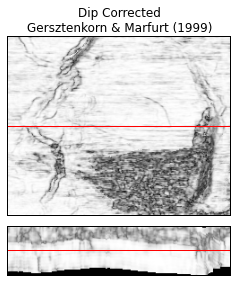

In [16]:
dip_corrected_gersztenkorn = dip_corrected(seismic, (3,3,9), gersztenkorn_eigenstructure)
plot(dip_corrected_gersztenkorn, 'Dip Corrected\nGersztenkorn & Marfurt (1999)')

Or apply it using Marfurt, et al's (1998) algorithm:

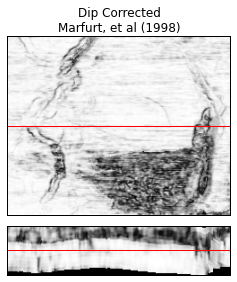

In [17]:
dip_corrected_marfurt = dip_corrected(seismic, (3,3,9), marfurt_semblance)
plot(dip_corrected_marfurt, 'Dip Corrected\nMarfurt, et al (1998)')

The effects of dip correction are less
apparent in our examples due to the relatively low structural dips in the area.
However, dip correction significantly enhances resolution of subtle features in
more structurally complex areas (Marfurt, 2006; Chopra and Marfurt, 2007).

Using the Analytic Trace
------------------------

In addition to dip correction, many authors recommend including the analytic trace in the discontinuity calculation (e.g.
Marfurt, et al, 1999, 2006; Chopra and Marfurt, 2007).  In principle, this
makes the discontinuity estimation less sensitive to zero-crossings in the
original dataset. As an example of applying this to
Gersztenkorn & Marfurt's (1999) algorithm:

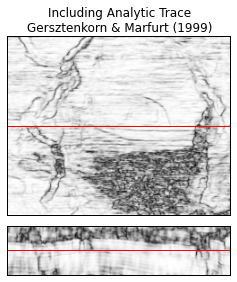

In [18]:
def complex_eigenstructure(region):
    region = region.reshape(-1, region.shape[-1])

    region = scipy.signal.hilbert(region, axis=-1)
    region = np.hstack([region.real, region.imag])

    cov = region.dot(region.T)
    vals = np.linalg.eigvals(cov)
    return np.abs(vals.max() / vals.sum())

complex_gersztenkorn = moving_window(seismic, (3,3,9), complex_eigenstructure)
plot(complex_gersztenkorn, 'Including Analytic Trace\nGersztenkorn & Marfurt (1999)')

In practice, including the analytic trace information often has a very minor effect.  For example, let's replot the "regular" version of Gersztenkorn & Marfurt's (1999) algorithm applied to this dataset. The differences between these two are almost unnoticable:

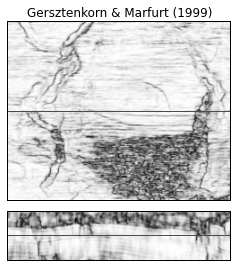

In [19]:
plot(gersztenkorn, 'Gersztenkorn & Marfurt (1999)')

Final Thoughts
---------------

Hopefully this tutorial has helped you "peek behind the curtains" at how discontinuity algorithms are implemented.  However, I've only brushed the surface here. There are many more coherence/discontinuity algorithms than the ones discussed above.  Chapter 2 of Chopra and Marfurt (2006) has an excellent review.  Many of the algorithms described there can be implemented using the "building blocks" shown in this tutorial.  If you're feeling ambitious, give it a try!

References
----------

Bahorich, M., and S. Farmer, 1995, 3-D seismic discontinuity for faults and stratigraphic features: The coherence cube: The Leading Edge, *14*, 1053-1058.
doi:10.1190/1.1437077

Chopra, S., and K. J. Marfurt, 2007, Seismic Attributes for Prospect Identification and Reservoir Characterization: *SEG*
doi:10.1190/1.9781560801900

Gersztenkorn, A., and K. J. Marfurt, 1999, Eigenstructure‐based coherence computations as an aid to 3-D structural and stratigraphic mapping: GEOPHYSICS, *64*, 1468-1479.
doi:10.1190/1.1444651

Marfurt, K., V. Sudhaker, A. Gersztenkorn, K. D. Crawford, and S. E. Nissen, 1999, Coherency calculations in the presence of structural dip: GEOPHYSICS, *64*, 104-111.
doi:10.1190/1.1444508

Marfurt, K. J., 2006, Robust estimates of 3D reflector dip and azimuth: GEOPHYSICS, *71*, no. 4, P29-P40.
doi:10.1190/1.2213049

Nova Scotia Department of Energy, 1992, Penobscot 3D Survey. Dataset accessed 19 October, 2015 at
https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND

Taner, M. T., And F. Koehler, 1969, Velocity Spectra—Digital Computer Derivation Applications of Velocity Functions: Geophysics, *34*, 859-881.
doi:10.1190/1.1440058
